# Machine Learning on Predicting Survivied Passenger during the Titanic Disaster

The objective of this project is to predict whether or not a passenger survived based on attributes including their age, sex, ticket class and so on.

## Part 1: Data Preparation

In [6]:
import pandas as pd

# loading data (source: https://www.kaggle.com/competitions/titanic/data)
train = pd.read_csv("D:/Data Science/machine learning/titanic project/train.csv")
test = pd.read_csv("D:/Data Science/machine learning/titanic project/test.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
# setting the PassengerId as index
train = train.set_index("PassengerId")
test = test.set_index("PassengerId")

In [9]:
# missing values
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [11]:
percent_missing = train.isnull().sum() * 100 / len(train)
missing_value_df = pd.DataFrame({'column_name': train.columns, 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df

,column_name,percent_missing
Survived,Survived,0.000000
Pclass,Pclass,0.000000
Name,Name,0.000000
Sex,Sex,0.000000
SibSp,SibSp,0.000000
Parch,Parch,0.000000
Ticket,Ticket,0.000000
Fare,Fare,0.000000
Embarked,Embarked,0.224467
Age,Age,19.865320


The **Age, Cabin** and **Embarked** attribtues contains null values. 

The **Cabin** attribute has about overwhemly 77% so that we might not use this attribute. The **Age** attibute has about 19% null values. Replacing its null values with overall median age. The **Embarked** attribute has only 2 null values. We will jusr replace them by the most frequent value. All implementation will be shown on pipeline construction below.

The **Name** and **Ticket** attributes are difficult to be converted into useful numerical attributes. We will ignore them.

In [15]:
# pipeline construction
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# for numerical attributes
num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

# for categorical attributes
from sklearn.preprocessing import OneHotEncoder
cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

# putting them together
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

In [16]:
# now, let's preprocessing our data using our pipeline
X_train = preprocess_pipeline.fit_transform(train[num_attribs + cat_attribs])
X_train

array([[-0.56573646,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.66386103,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.1046374 ,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276197, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

In [17]:
# getting labels
y_train = train["Survived"]

## Part 2: Model Training & Testing

In this case, we need to train a binary classifier. Let's start with a RandomForest classifier

### Model 1: RandomForest classifier

In [18]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [19]:
X_test = preprocess_pipeline.transform(test[num_attribs + cat_attribs])
y_pred = forest_clf.predict(X_test)

from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8092759051186016

It does not seem too bad. but we can do better!

Let's try a support vector machine classifier:

### Model 2: Support Vector Machine Classifier

In [20]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.8249313358302123

Slightly better! Instead of comparing two mean scores, we better consider their performance over 10 cross-validation folds.

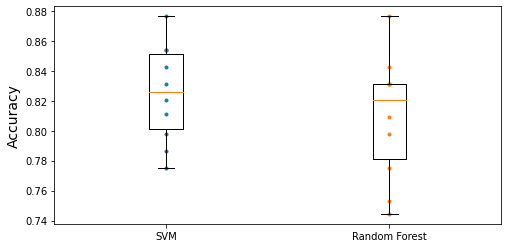

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

It's clear that Random Forest classifier get a better score on one of 10 folds. But overall, support vector machine performs better.

### Can we improve this result further?

Some ideas:

* compare more models and finalize hyperparameters using cross validation and grid search.
* more feature engineering
    + convert numerical attributes to categorical attributes: age group, travelling-alone/or-not, etc
    + counting the number of relatives on board
